# Aprendizagem Automática 2023/24
## Third Home Assignment
Group 38: Steinbach Lea (62435), Pirotte Antoine (62398) and Haselon Frederic (62414)

### Imports, useful functions and storing

Both functions are taken from previous Lab classes.

In [9]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor


from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, KernelPCA

def gaussian(dsts):
    kernel_width = .5
    weights = np.exp(-(dsts**2)/kernel_width)
    return weights

We store the values so that we do not need to run everything each time we restart working in the notebook. You can ignore the part where we use them.

In [10]:
%store -r X_train_complete
%store -r X_ivs
%store -r y_train_complete
%store -r col_names

%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

%store -r X_train_MMscaled
%store -r X_train_Sscaled
%store -r X_train_Ptransformer
%store -r X_test_MMscaled
%store -r X_test_Sscaled
%store -r X_test_Ptransformer

%store -r X_train_feature_selection
%store -r X_train_Sscaled_feature_selection
%store -r X_train_MMscaled_feature_selection
%store -r X_train_Ptransformer_feature_selection
%store -r X_test_feature_selection
%store -r X_test_Sscaled_feature_selection
%store -r X_test_MMscaled_feature_selection
%store -r X_test_Ptransformer_feature_selection

%store -r X_train_Sscaled_PCA
%store -r X_test_Sscaled_PCA

%store -r X_train_Sscaled_kernelPCA_poly
%store -r X_test_Sscaled_kernelPCA_poly

%store -r Features_selected_non_scaled

### Investigate and prepare the Dataset

We import the data as asked in the instructions.

In [4]:
X_train_complete, X_ivs, y_train_complete, col_names = pickle.load(open("drd2_data.pickle", "rb")) # we get the dataset
%store X_train_complete
%store X_ivs
%store y_train_complete
%store col_names

Stored 'X_train_complete' (ndarray)
Stored 'X_ivs' (ndarray)
Stored 'y_train_complete' (ndarray)
Stored 'col_names' (list)


We check for missing values in the dataset.

In [5]:
print(X_train_complete.shape)

print(X_train_complete[0][0], type(X_train_complete[0][0])) # we get the type of the first value in the train dataset

x_type = type(X_train_complete[0][0])

for lines in X_train_complete:
  for x in lines:
    if not isinstance(x, x_type): # we check if there are missing values
      print("not float")

(7337, 2132)
541.28013798 <class 'numpy.float64'>


Since there are no missing values, we can skip the imputation.

In [6]:
df = pd.DataFrame(X_train_complete)
print(df.iloc[:,41:46].head())
# we can see that the values inside the columns with the name "FPXXXX" are categorical, we don't need to scale them
print(df.head()) # we take a look at the dataset
#print(pd.DataFrame(X_ivs).head())
#print(y_train_complete)
# print(col_names)

          41         42   43   44   45
0   4.577007   6.932531  0.0  0.0  0.0
1   4.766210   7.001034  0.0  0.0  0.0
2   3.641782   4.738475  0.0  0.0  0.0
3  21.871193  28.304864  0.0  0.0  0.0
4   4.143126   5.412062  0.0  0.0  0.0
          0         1     2     3     4     5     6      7      8     9     \
0   541.280138   541.656  10.0   1.0   8.0   1.0  10.0   40.0   75.0  10.0   
1   426.197714   426.582   5.0   1.0   9.0   1.0   4.0   30.0   60.0   6.0   
2   348.183778   348.446   4.0   0.0   3.0   0.0   3.0   26.0   50.0   4.0   
3  1455.763803  1456.831  27.0  19.0  23.0  17.0  16.0  105.0  206.0  28.0   
4   387.151368   387.886   4.0   0.0   4.0   0.0   4.0   27.0   50.0   6.0   

   ...  2122  2123  2124  2125  2126  2127  2128  2129  2130  2131  
0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2  ...   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3  ...   0.0   0.0   

And finally we prepare the dataset to be used for the regression and we divide the training dataset in the train/test sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_train_complete, y_train_complete, test_size=0.25, random_state=1337)
%store X_train
%store X_test
%store y_train
%store y_test

Stored 'X_train' (ndarray)
Stored 'X_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)


## Data Scaling

We create the scaled dataset to fit our model. The scaled data might give better results than non-scaled data and needs to be tested.

We first seperate the continuous variables from the categorical ones. We will only scale the continuous variables.

In [11]:
X_train_continuous, X_train_categorical = X_train[:, :43], X_train[:, 43:]
X_test_continuous, X_test_categorical = X_test[:, :43], X_test[:, 43:]

In [12]:
# Standard Scaler for Logistic Regression & MinMax for Naive Bayes
MMscaler = MinMaxScaler()
Sscaler = StandardScaler()
Ptransformer = PowerTransformer()

# It scaler with training data
MMscaler.fit(X_train_continuous)
Sscaler.fit(X_train_continuous)
Ptransformer.fit(X_train_continuous)

# Transform train & test set with MinMax scaler
X_train_MMscaled = MMscaler.transform(X_train_continuous)
X_test_MMscaled = MMscaler.transform(X_test_continuous)
# Transform train & test set with Standard scaler
X_train_Sscaled = Sscaler.transform(X_train_continuous)
X_test_Sscaled = Sscaler.transform(X_test_continuous)
# Transform train & test set with Standard scaler
X_train_Ptransformer = Ptransformer.transform(X_train_continuous)
X_test_Ptransformer = Ptransformer.transform(X_test_continuous)

We recombine the two arrays into one.

In [13]:
X_train_MMscaled = np.hstack((X_train_MMscaled, X_train_categorical))
X_train_Sscaled = np.hstack((X_train_Sscaled, X_train_categorical))
X_train_Ptransformer = np.hstack((X_train_Ptransformer, X_train_categorical))

X_test_MMscaled = np.hstack((X_test_MMscaled, X_test_categorical))
X_test_Sscaled = np.hstack((X_test_Sscaled, X_test_categorical))
X_test_Ptransformer = np.hstack((X_test_Ptransformer, X_test_categorical))

%store X_train_MMscaled
%store X_train_Sscaled
%store X_train_Ptransformer

%store X_test_MMscaled
%store X_test_Sscaled
%store X_test_Ptransformer

Stored 'X_train_MMscaled' (ndarray)
Stored 'X_train_Sscaled' (ndarray)
Stored 'X_train_Ptransformer' (ndarray)
Stored 'X_test_MMscaled' (ndarray)
Stored 'X_test_Sscaled' (ndarray)
Stored 'X_test_Ptransformer' (ndarray)


## Imputation

As said above, there are no missing values. There is then no need to impute any data.

## Feature selection
Since there are a lot of variable (2132), feature selection could improve the computation time and the results of the models.

In [11]:
N,M=X_train.shape

### Correlation

In [12]:
v=np.hstack((y_train.reshape((N,1)), X_train))

df = pd.DataFrame(np.corrcoef(v.T))

threshold = 0.1

selected_features = []

count = 0
maximum = 0
for locs, vals in enumerate(df.loc[0].drop(0)):
    if abs(vals) >= threshold:
        count += 1
        #print(locs+1, vals)
        selected_features.append(locs)
        if abs(vals) >= abs(maximum):
            maximum = vals
print(maximum)
print(count)

0.28925741735098376
160


We select the features in all the datasets.

In [13]:
# Selection of the features in non-scaled data
X_train_corrSelection = X_train[:, selected_features]
X_test_corrSelection = X_test[:,selected_features]
print(X_train_corrSelection.shape)
# Selection of the features in scaled data
X_train_MMscaled_corrSelection = X_train_MMscaled[:, selected_features]
X_test_MMscaled_corrSelection = X_test_MMscaled[:,selected_features]

X_train_Sscaled_corrSelection = X_train_Sscaled[:, selected_features]
X_test_Sscaled_corrSelection = X_test_Sscaled[:,selected_features]

(5502, 160)


### Random forests

In [14]:
rfr=RandomForestRegressor(n_jobs=-1)
sel_non_scaled = SelectFromModel(estimator=rfr, threshold=.001)

sel_non_scaled.fit(X_train, y_train)

features_non_scaled=sel_non_scaled.get_support()

Features_selected_non_scaled =np.arange(M)[features_non_scaled]

print("The features selected are columns: ", Features_selected_non_scaled)

%store Features_selected_non_scaled

The features selected are columns:  [   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   15   16   17   19   22   23   24   25   26   27   28   29   30   31
   32   33   34   35   36   37   38   39   40   41   42   52   74   83
   96  103  108  180  186  199  216  246  287  316  336  347  348  353
  362  364  377  386  440  442  444  472  494  513  546  551  561  570
  608  679  695  717  769  778  790  811  815  819  839  853  871  879
  886  891  909  924  939  950  956  959  981  982 1013 1020 1041 1054
 1063 1075 1121 1147 1161 1176 1209 1214 1279 1285 1338 1440 1454 1488
 1499 1527 1528 1540 1575 1598 1604 1641 1649 1652 1667 1687 1709 1752
 1766 1777 1783 1787 1811 1815 1839 1841 1868 1918 1921 1922 1934 1968
 1992 1998 2069 2098 2122]
Stored 'Features_selected_non_scaled' (ndarray)


We will use the Random forests feature selection to use on our datasets.

In [15]:
X_train_feature_selection = X_train[:,Features_selected_non_scaled]
X_train_Sscaled_feature_selection = X_train_Sscaled[:,Features_selected_non_scaled]
X_train_MMscaled_feature_selection = X_train_MMscaled[:,Features_selected_non_scaled]
X_train_Ptransformer_feature_selection = X_train_Ptransformer[:,Features_selected_non_scaled]

X_test_feature_selection = X_test[:,Features_selected_non_scaled]
X_test_Sscaled_feature_selection = X_test_Sscaled[:,Features_selected_non_scaled]
X_test_MMscaled_feature_selection = X_test_MMscaled[:,Features_selected_non_scaled]
X_test_Ptransformer_feature_selection = X_test_Ptransformer[:,Features_selected_non_scaled]

%store X_train_feature_selection
%store X_train_Sscaled_feature_selection
%store X_train_MMscaled_feature_selection
%store X_train_Ptransformer_feature_selection

%store X_test_feature_selection
%store X_test_Sscaled_feature_selection
%store X_test_MMscaled_feature_selection
%store X_test_Ptransformer_feature_selection

Stored 'X_train_feature_selection' (ndarray)
Stored 'X_train_Sscaled_feature_selection' (ndarray)
Stored 'X_train_MMscaled_feature_selection' (ndarray)
Stored 'X_train_Ptransformer_feature_selection' (ndarray)
Stored 'X_test_feature_selection' (ndarray)
Stored 'X_test_Sscaled_feature_selection' (ndarray)
Stored 'X_test_MMscaled_feature_selection' (ndarray)
Stored 'X_test_Ptransformer_feature_selection' (ndarray)


## Principal Component Analysis

### Linear PCA

In [16]:
pca = PCA(n_components=300) # maybe try with less or more components
pca.fit(X_train_Sscaled) # we use the data scaled with standard scaler since it follows the two rules for PCA : centered and unit variance
tve=0
for i, ve in enumerate(pca.explained_variance_ratio_):
    tve+=ve
    print("PC%d - Variance explained: %7.4f - Total Variance: %7.4f" % (i, ve, tve) )
print()

PC0 - Variance explained:  0.2461 - Total Variance:  0.2461
PC1 - Variance explained:  0.0416 - Total Variance:  0.2877
PC2 - Variance explained:  0.0318 - Total Variance:  0.3195
PC3 - Variance explained:  0.0284 - Total Variance:  0.3479
PC4 - Variance explained:  0.0207 - Total Variance:  0.3686
PC5 - Variance explained:  0.0175 - Total Variance:  0.3860
PC6 - Variance explained:  0.0167 - Total Variance:  0.4028
PC7 - Variance explained:  0.0126 - Total Variance:  0.4153
PC8 - Variance explained:  0.0123 - Total Variance:  0.4276
PC9 - Variance explained:  0.0113 - Total Variance:  0.4390
PC10 - Variance explained:  0.0101 - Total Variance:  0.4491
PC11 - Variance explained:  0.0095 - Total Variance:  0.4586
PC12 - Variance explained:  0.0085 - Total Variance:  0.4671
PC13 - Variance explained:  0.0080 - Total Variance:  0.4751
PC14 - Variance explained:  0.0078 - Total Variance:  0.4830
PC15 - Variance explained:  0.0072 - Total Variance:  0.4901
PC16 - Variance explained:  0.0068

We then transform the dataset.

In [17]:
X_train_Sscaled_PCA=pca.transform(X_train_Sscaled)
X_test_Sscaled_PCA=pca.transform(X_test_Sscaled)
print(X_train_Sscaled_PCA.shape)

%store X_train_Sscaled_PCA
%store X_test_Sscaled_PCA

(5502, 300)
Stored 'X_train_Sscaled_PCA' (ndarray)
Stored 'X_test_Sscaled_PCA' (ndarray)


### Kernel PCA

In [18]:
kpca_poly = KernelPCA(n_components=200, kernel='poly', gamma=3)
kpca_poly.fit(X_train_Sscaled)

KernelPCA(gamma=3, kernel='poly', n_components=200)

In [20]:
X_train_Sscaled_kernelPCA_poly=kpca_poly.transform(X_train_Sscaled)
X_test_Sscaled_kernelPCA_poly=kpca_poly.transform(X_test_Sscaled)
print(X_train_Sscaled_kernelPCA_poly.shape)

(5502, 200)


In [21]:
%store X_train_Sscaled_kernelPCA_poly
%store X_test_Sscaled_kernelPCA_poly

Stored 'X_train_Sscaled_kernelPCA_poly' (ndarray)
Stored 'X_test_Sscaled_kernelPCA_poly' (ndarray)


## Regression
We use simple cross-validation for all models. We use the Ratio of the variance explained (RVE), the root mean squared error (rmse) and the Mean absolute error (MAE) to evaluate our models. Every model is tested with each set of data (non-scaled and scaled with both scaler), with the PCA and with feature seletion.

In [5]:
def test_model(model, XTrain, XTest):
    model.fit(XTrain, y_train)
    preds = model.predict(XTest)
    return explained_variance_score(y_test, preds) # TODO change to have more scores

train_datasets = [X_train, X_train_MMscaled, X_train_Sscaled, X_train_Ptransformer, \
                  X_train_feature_selection, X_train_MMscaled_feature_selection, X_train_Sscaled_feature_selection, X_train_Ptransformer_feature_selection, \
                  X_train_Sscaled_PCA, X_train_Sscaled_kernelPCA_poly]
train_datasets_str = ["X_train", "X_train_MMscaled", "X_train_Sscaled", "X_train_Ptransformer", \
                  "X_train_feature_selection", "X_train_MMscaled_feature_selection", "X_train_Sscaled_feature_selection", "X_train_Ptransformer_feature_selection", \
                  "X_train_Sscaled_PCA", "X_train_Sscaled_kernelPCA_poly"]

test_datasets = [X_test, X_test_MMscaled, X_test_Sscaled, X_test_Ptransformer, \
                 X_test_feature_selection, X_test_MMscaled_feature_selection, X_test_Sscaled_feature_selection, X_test_Ptransformer_feature_selection, \
                 X_test_Sscaled_PCA, X_test_Sscaled_kernelPCA_poly]
test_datasets_str = ["X_test", "X_test_MMscaled", "X_test_Sscaled", "X_test_Ptransformer", \
                 "X_test_feature_selection", "X_test_MMscaled_feature_selection", "X_test_Sscaled_feature_selection", "X_test_Ptransformer_feature_selection", \
                 "X_test_Sscaled_PCA", "X_test_Sscaled_kernelPCA_poly"]

### Default models

We will first try the default parameters for each model. This way we will eliminate the models which give bad results without trying them with too much parameters.

#### Decision Tree

In [23]:
scores = []

for i in range(len(train_datasets)):
    if i%3 == 0:
        print(i) # to see the advancment of the loop
    mdl = DecisionTreeRegressor()
    scores.append(test_model(mdl, train_datasets[i], test_datasets[i]))

print(scores)

0
3
6
9
[0.2983520570785265, 0.28558576425132154, 0.2560757544966591, 0.2757939506184919, 0.2182880178099612, 0.25277018963535736, 0.23661546376559794, 0.2364615254841247, 0.08286760335828924, 0.11868110861420345]


#### Linear Model

In [24]:
scores = []

for i in range(len(train_datasets)):
    if i%3 == 0:
        print(i)
    mdl = LinearRegression()
    scores.append(test_model(mdl, train_datasets[i], test_datasets[i]))

print(scores)

0
3
6
9
[0.37486572539264906, 0.37481739945187953, 0.3748060671533886, 0.36015659692364266, 0.3894761898188879, 0.3894761898189165, 0.3894761898189125, 0.3943112567337146, 0.5267700601399774, 0.27080483586424076]


#### Naive Bayes
Not suitable for regression.

#### K-Nearest Neighbors

In [25]:
scores = []

for i in range(len(train_datasets)):
    if i%3 == 0:
        print(i)
    mdl = KNeighborsRegressor()
    scores.append(test_model(mdl, train_datasets[i], test_datasets[i]))

print(scores)

0
3
6
9
[0.23223198335789275, 0.59482777080221, 0.6057009131238534, 0.6083904158754849, 0.14489153950157563, 0.604963169198643, 0.6022209268745943, 0.5939495850776265, 0.630214768587202, 0.5603274036400057]


#### Support Vector Machines

In [26]:
scores = []

for i in range(len(train_datasets)):
    if i%3 == 0:
        print(i)
    mdl = SVR()
    scores.append(test_model(mdl, train_datasets[i], test_datasets[i]))

print(scores)

0
3
6
9
[0.09820904703781042, 0.6413238662894807, 0.6460252152994559, 0.651957042340409, 0.07992536387096816, 0.6128008330487797, 0.6019551943877013, 0.6229865367746386, 0.6606712661371408, 0.12894586081278547]


#### Random Forest

In [27]:
scores = []

for i in range(len(train_datasets)):
    if i%3 == 0:
        print(i)
    mdl = RandomForestRegressor(n_jobs=-1)
    scores.append(test_model(mdl, train_datasets[i], test_datasets[i]))

print(scores)

0
3
6
9
[0.6344115229227772, 0.6311785336826297, 0.6330391504472823, 0.6371650366957466, 0.6060880069989003, 0.6048039575066566, 0.6028508488860002, 0.6084385809657895, 0.5454183604922485, 0.5770143192651316]


#### AdaBoost

In [28]:
scores = []

for i in range(len(train_datasets)):
    if i%3 == 0:
        print(i)
    mdl = AdaBoostRegressor()
    scores.append(test_model(mdl, train_datasets[i], test_datasets[i]))

print(scores)

0
3
6
9
[0.18987113207129613, 0.18493317791859643, 0.18804106021359934, 0.17658841476753695, 0.20155318077058337, 0.20401039700667678, 0.18564423407170272, 0.18857348546958463, 0.19064312564456998, 0.24682028637659403]


#### XGBoost

In [29]:
scores = []

for i in range(len(train_datasets)):
    if i%3 == 0:
        print(i)
    mdl = XGBRegressor()
    scores.append(test_model(mdl, train_datasets[i], test_datasets[i]))

print(scores)

0
3
6
9
[0.6229232236516025, 0.6247798698763536, 0.6229232236516025, 0.6229232236516025, 0.5789438011335175, 0.5826674234454989, 0.5789438011335175, 0.5789438011335175, 0.5443329306862341, 0.5531691395186005]


#### Multilayer Perceptrons (Neural Network)

In [30]:
scores = []

for i in range(len(train_datasets)):
    if i%3 == 0:
        print(i)
    mdl = MLPRegressor()
    scores.append(test_model(mdl, train_datasets[i], test_datasets[i]))

print(scores)

0
3
6
9
[0.3743570109609965, 0.5849531921217801, 0.5598167217496366, 0.5743700536697962, 0.19686495987853625, 0.4699422932986661, 0.5272830140251008, 0.5352310447458891, 0.48760549980752743, -5297214.368400508]


After these tests, we will then choose the following ones :
- K-nearest neighbours
- Support vector machine
- Random forest
- XGBoost
- Multilayer perceptron

### Final models
We will test the 5 chosen models here.

#### K-nearest neighbours

In [31]:
RVE = []

for i in range(len(train_datasets)):
    mdl = KNeighborsRegressor()
    RVE.append(test_model(mdl, train_datasets[i], test_datasets[i]))

In [32]:
KNN_train_datasets = []
KNN_test_datasets = []

best_RVE = sorted(RVE, reverse=True)[0:3] # we choose the 3 best datasets
for RVEs in best_RVE:
    index = RVE.index(RVEs)
    print(train_datasets_str[index]) # these are the datasets used
    KNN_train_datasets.append(train_datasets[index])
    KNN_test_datasets.append(test_datasets[index])


X_train_Sscaled_PCA
X_train_Ptransformer
X_train_Sscaled


We now have the best three datasets to iterate on.

In [33]:
RVE = []
n_neighbours = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]

for i in range(len(n_neighbours)):
    mdl = KNeighborsRegressor(n_neighbors=n_neighbours[i])
    RVE.append(test_model(mdl, KNN_train_datasets[0], KNN_test_datasets[0]))

[3, 4, 5, 6, 7, 8, 9]


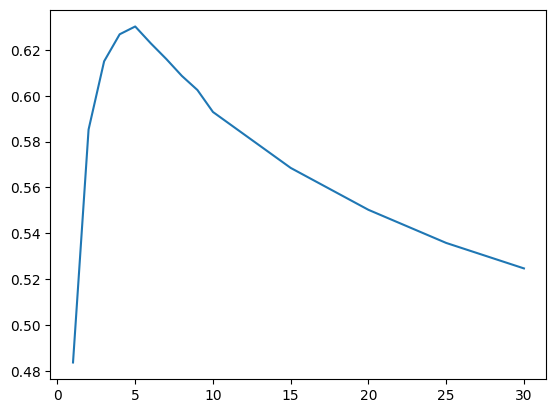

In [34]:
plt.plot(n_neighbours, RVE)
best_n_neighbour_index = RVE.index(max(RVE))

best_n_neighbours = n_neighbours[best_n_neighbour_index-2:best_n_neighbour_index+5]

print(best_n_neighbours)


In [35]:
RVE = []
RVE_KNN = []
weights = ["uniform", "distance"]

for i in range(len(KNN_train_datasets)):
    print("new dataset")
    RVE = []
    for weight in weights:
        for n_neigh in best_n_neighbours:
            mdl=KNeighborsRegressor(n_neighbors=n_neigh, weights=weight)
            RVE.append(test_model(mdl, KNN_train_datasets[i], KNN_test_datasets[i]))
    RVE_KNN.append(np.array(RVE).reshape(len(weights),len(best_n_neighbours)))

new dataset
new dataset
new dataset


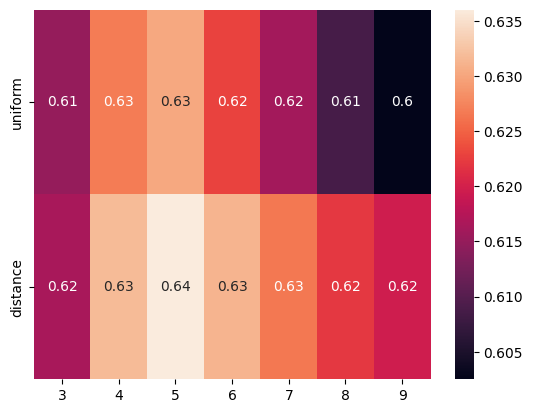

3    0.6164
4    0.6318
5    0.6360
6    0.6312
7    0.6265
8    0.6221
9    0.6196
dtype: float64


/Users/frederic/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


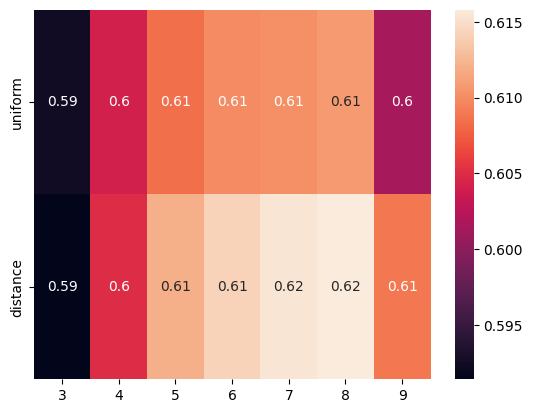

/Users/frederic/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


3    0.5925
4    0.6050
5    0.6120
6    0.6142
7    0.6154
8    0.6158
9    0.6089
dtype: float64


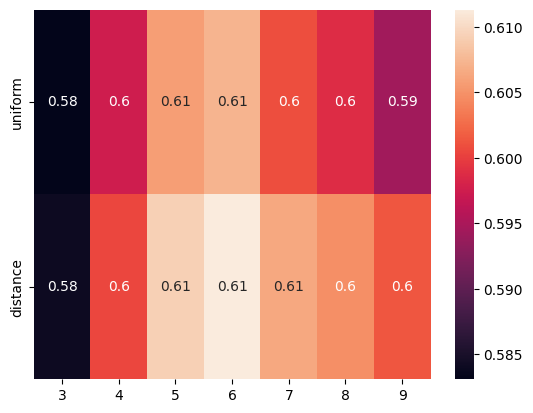

3    0.5840
4    0.6005
5    0.6093
6    0.6113
7    0.6064
8    0.6047
9    0.6013
dtype: float64


/Users/frederic/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [36]:
HeatMap_KNN_df = []
for i in range(len(RVE_KNN)):
    HeatMap_KNN_df.append(pd.DataFrame(RVE_KNN[i], columns = best_n_neighbours, index = weights).round(4))
    sns.heatmap(data=HeatMap_KNN_df[i], annot=True, xticklabels=best_n_neighbours, yticklabels=weights)
    plt.show()
    print(np.max(HeatMap_KNN_df[i]))

We can see that the best result is with the dataset of linear PCA, 5 neighbours and the distance weights. It achieves an RVE of 0.635.

#### Support vector machine

In [37]:
RVE = []

for i in range(len(train_datasets)):
    mdl = SVR()
    RVE.append(test_model(mdl, train_datasets[i], test_datasets[i]))

In [38]:
SVR_train_datasets = []
SVR_test_datasets = []
SVR_train_datasets_str = []

best_RVE = sorted(RVE, reverse=True)[0:3] # we choose the 3 best datasets
for RVEs in best_RVE:
    index = RVE.index(RVEs)
    print(train_datasets_str[index]) # these are the datasets used
    SVR_train_datasets.append(train_datasets[index])
    SVR_test_datasets.append(test_datasets[index])
    SVR_train_datasets_str.append(train_datasets_str[index])


X_train_Sscaled_PCA
X_train_Ptransformer
X_train_Sscaled


In [39]:
RVE = []
kernels = ["linear", "poly", "rbf"]

for i in range(len(kernels)):
    mdl = SVR(kernel=kernels[i])
    RVE.append(test_model(mdl, SVR_train_datasets[0], SVR_test_datasets[0]))

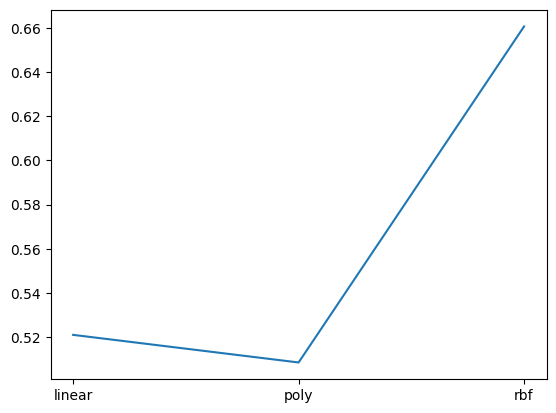

In [40]:
plt.plot(kernels, RVE) # we are going to only test with rbf since its results are much better than the other three
# we tested sigmoid and it gave us a result of -160000

In [41]:
RVE = []
degrees = [1, 2, 3, 4, 5, 6]

for i in range(len(degrees)):
    mdl = SVR(degree=degrees[i], kernel="poly")
    RVE.append(test_model(mdl, SVR_train_datasets[0], SVR_test_datasets[0]))

[0.5201559450127335, 0.6300254038548312, 0.5084888809080679, -0.05137074878005654, -1418.8934432760425, -11496.517352819092]


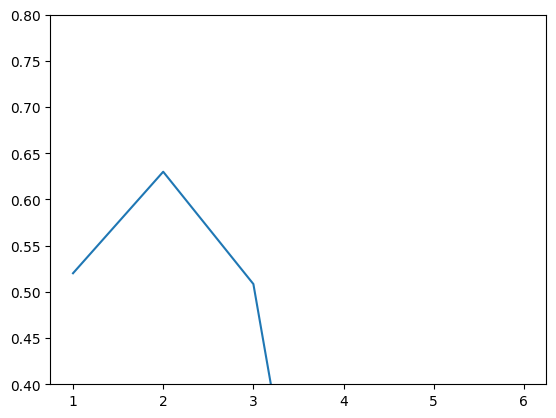

In [42]:
plt.plot(degrees, RVE)
plt.ylim([0.4, 0.8])
print(RVE)
# the result with a degree of 2 is quite good but still not good enough to switch to the poly kernel

In [43]:
RVE = []
tols = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

for i in range(len(tols)):
    mdl = SVR(tol=tols[i])
    RVE.append(test_model(mdl, SVR_train_datasets[0], SVR_test_datasets[0]))

[0.6606717716495067, 0.66067154675174, 0.6606697290197383, 0.6606712661371408, 0.6607674334223322, 0.6533646871380128]


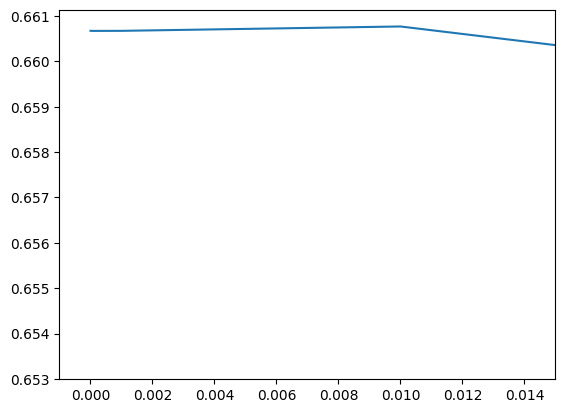

In [44]:
plt.plot(tols, RVE)
plt.xlim([-0.001, 0.015])
print(RVE)
# since the difference between the different values is really small, we are going to keep the default parameter

In [45]:
RVE = []
Cs = [0.001, 0.01, 0.1, 0.5, 1, 10]

for i in range(len(Cs)):
    mdl = SVR(C=Cs[i])
    RVE.append(test_model(mdl, SVR_train_datasets[0], SVR_test_datasets[0]))

[0.10057763516374962, 0.3563441601960451, 0.5893937214234253, 0.6503682820964067, 0.6606712661371408, 0.6464579907813064]


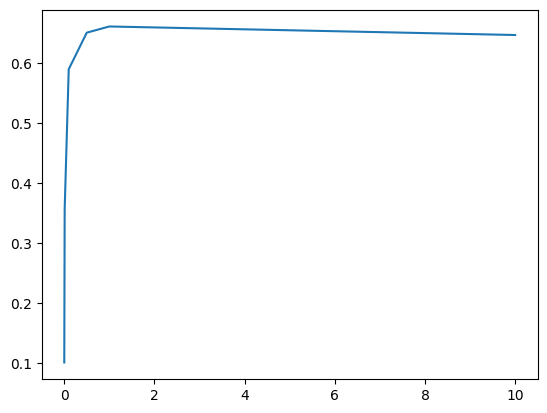

In [46]:
plt.plot(Cs, RVE)
print(RVE)
# since the difference between the different values is really small, we are going to keep the default parameter

In [47]:
RVE = []
epsilons = [0.001, 0.01, 0.1, 0.2]

for i in range(len(epsilons)):
    mdl = SVR(epsilon=epsilons[i])
    RVE.append(test_model(mdl, SVR_train_datasets[0], SVR_test_datasets[0]))

[0.6753279771283667, 0.6766602688994732, 0.6606712661371408, 0.5955165534153659]


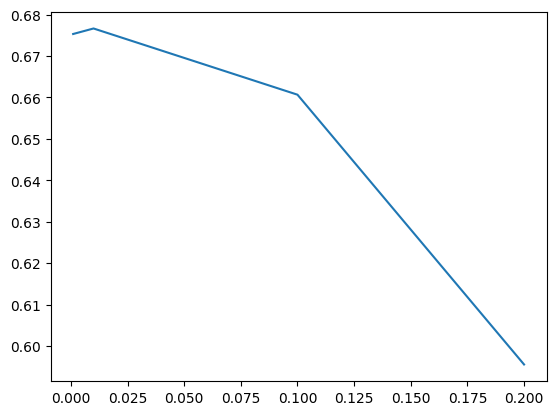

In [48]:
plt.plot(epsilons, RVE)
print(RVE)
# since the difference between the different values is really small, we are going to keep the default parameter

In our final model, we will only change the value of epsilon since he default parameter always gives the best result and the simplest model is preferred.

In [49]:
RVE = []
RVE_SVR = []
epsilons = [0.001, 0.01, 0.1, 0.2]

for i in range(len(KNN_train_datasets)):
    print("new dataset")
    RVE = []
    for epsilon in epsilons:
        mdl=SVR(epsilon=epsilon)
        RVE.append(test_model(mdl, SVR_train_datasets[i], SVR_test_datasets[i]))
    RVE_SVR.append(np.array(RVE).reshape(len(epsilons)))

new dataset
new dataset
new dataset


[array([0.67532798, 0.67666027, 0.66067127, 0.59551655]), array([0.67502794, 0.67566512, 0.65195704, 0.57408343]), array([0.66716897, 0.66780974, 0.64602522, 0.57344713])]


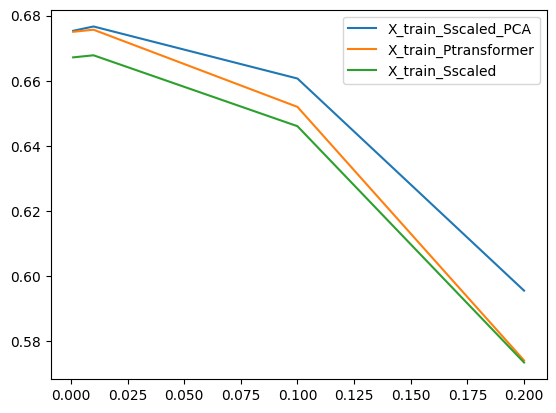

In [50]:
print(RVE_SVR)
for i in range(len(RVE_SVR)):
    plt.plot(epsilons, RVE_SVR[i], label=SVR_train_datasets_str[i])
plt.legend()

We can see that the best result is with the dataset of linear PCA and an epsilon of 0.01. It achieves an RVE of 0.676.

#### Random Forests

In [38]:
RVE = []

for i in range(len(train_datasets)):
    mdl = RandomForestRegressor(n_jobs=-1)
    RVE.append(test_model(mdl, train_datasets[i], test_datasets[i]))


In [39]:
RF_train_datasets = []
RF_test_datasets = []
RF_train_datasets_str = []

best_RVE = sorted(RVE, reverse=True)[0:3] # we choose the 3 best datasets
for RVEs in best_RVE:
    index = RVE.index(RVEs)
    print(train_datasets_str[index]) # these are the datasets used
    RF_train_datasets.append(train_datasets[index])
    RF_test_datasets.append(test_datasets[index])
    RF_train_datasets_str.append(train_datasets_str[index])


X_train_MMscaled
X_train
X_train_Ptransformer


We now have the best three datasets to iterate on.

In [40]:
RVE = []
n_estimators = [25,50,75,100,125,150,200,300]

for i in range(len(n_estimators)):
    mdl = RandomForestRegressor(n_estimators=n_estimators[i], n_jobs=-1)
    RVE.append(test_model(mdl, RF_train_datasets[0], RF_test_datasets[0]))

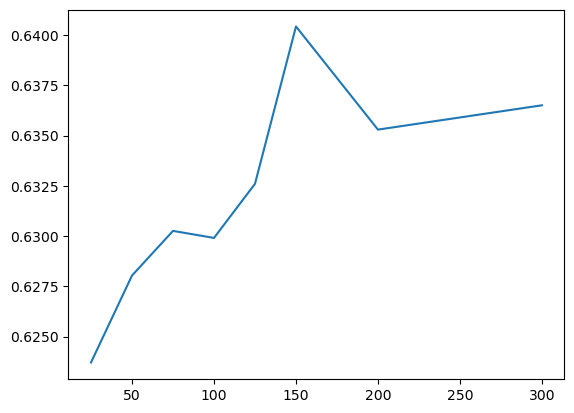

[0.6237094162088344, 0.6280350275262354, 0.6302553212395364, 0.6299054168341114, 0.6325966699951726, 0.640424117010864, 0.6352940695234774, 0.6365029568254503]


In [41]:
plt.plot(n_estimators, RVE)
plt.show()
print(RVE)

**n_estimators:** When testing different values for n_estimators, the values differed quite a lot.
We chose to keep the default parameter (=100) as there is no clear tendency of better results when further increasing n_estimators.

In [42]:
RVE = []
max_depths = [1,10,20,25,30,35,40,45,50,100]

for i in range(len(max_depths)):
    mdl = RandomForestRegressor(max_depth=max_depths[i], n_jobs=-1)
    RVE.append(test_model(mdl, RF_train_datasets[0], RF_test_datasets[0]))

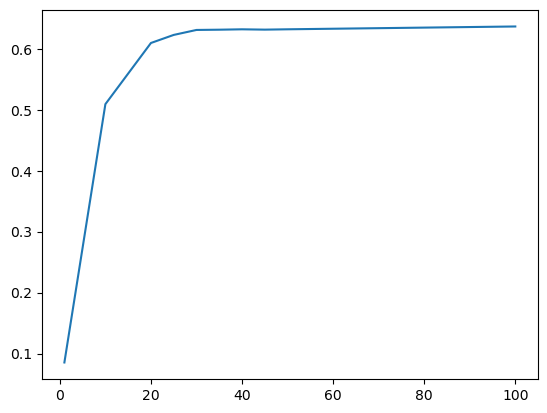

In [43]:
plt.plot(max_depths, RVE)

best_max_depths_index = RVE.index(max(RVE))

best_max_depths = [20, 25, 30, 35, 40]
# We will choose these depths to iterate on as they gave close to the best results while being the smallest

**max_depths:** range of -2/+2 around the maximum(=30), stabilizes after maximum

In [44]:
RVE = []
min_samples_leaf = [1,2,3,4,5]

for leaf in min_samples_leaf:
    mdl=RandomForestRegressor(min_samples_leaf=leaf, n_jobs=-1)
    RVE.append(test_model(mdl, RF_train_datasets[0], RF_test_datasets[0]))

[0.6336213473341765, 0.6358348380618074, 0.6320896058166577, 0.623433340559539, 0.6192478889164429]


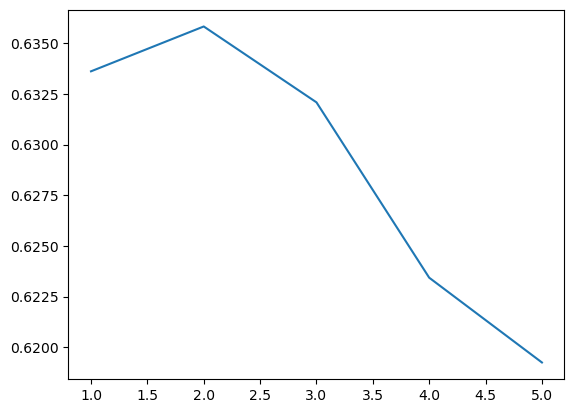

In [45]:
plt.plot(min_samples_leaf, RVE)
print(RVE)
plt.show()

best_min_samples_leaf = [1, 2, 3]
# we will use the parameters above for min_samples_leaf

In [46]:
RVE = []
criterions = ["squared_error", "absolute_error", "friedman_mse", "poisson"]

for criterion in criterions:
    mdl=RandomForestRegressor(criterion=criterion, n_jobs=-1)
    RVE.append(test_model(mdl, RF_train_datasets[0], RF_test_datasets[0]))

[0.632549501825495, 0.6367751281645949, 0.6336167776001224, 0.6230893968292723]


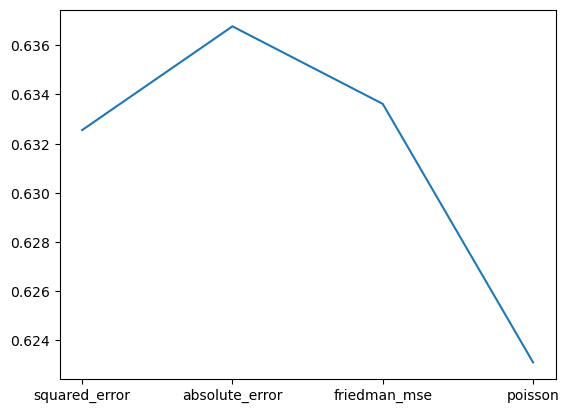

In [47]:
plt.plot(criterions, RVE)
print(RVE)
plt.show()
# we will keep the default parameter of "squared_error" since it is the second best and not by a lot

In [48]:
RVE = []
RVE_RF = []

for i in range(len(RF_train_datasets)):
    print("new dataset")
    RVE = []
    for depth in best_max_depths:
        for leaf in best_min_samples_leaf:
            mdl=RandomForestRegressor(min_samples_leaf=leaf, max_depth=depth, n_jobs=-1)
            RVE.append(test_model(mdl, RF_train_datasets[i], RF_test_datasets[i]))
    RVE_RF.append(np.array(RVE).reshape(len(best_max_depths),len(best_min_samples_leaf)))

new dataset
new dataset
new dataset


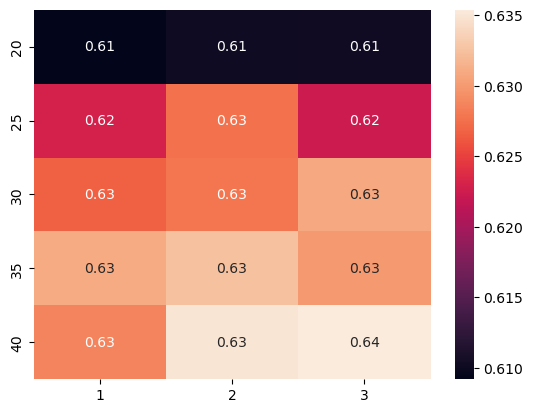

C:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


1    0.6310
2    0.6349
3    0.6354
dtype: float64


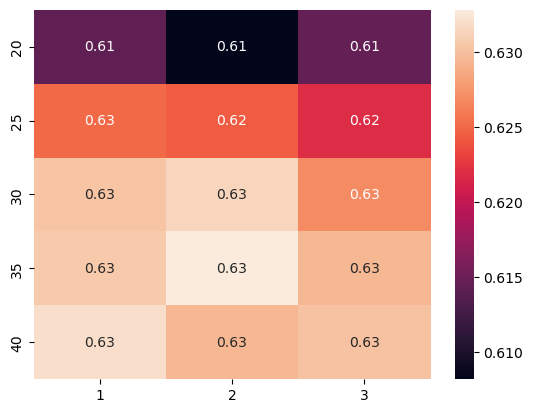

C:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


1    0.6320
2    0.6328
3    0.6302
dtype: float64


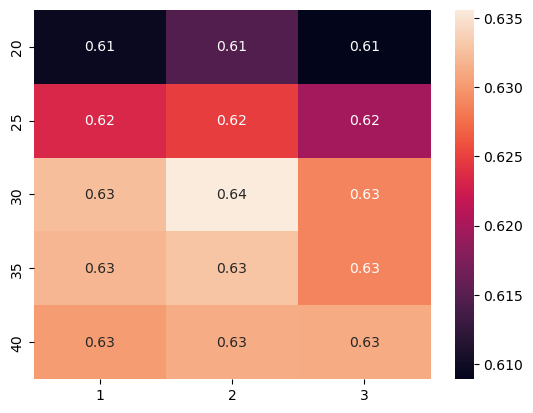

1    0.6324
2    0.6356
3    0.6312
dtype: float64


C:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [49]:
HeatMap_RF_df = []
for i in range(len(RVE_RF)):
    HeatMap_RF_df.append(pd.DataFrame(RVE_RF[i], columns = best_min_samples_leaf, index = best_max_depths).round(4))
    sns.heatmap(data=HeatMap_RF_df[i], annot=True, xticklabels=best_min_samples_leaf, yticklabels=best_max_depths)
    plt.show()
    print(np.max(HeatMap_RF_df[i]))

The best results for this model were achieved with the Power transformer dataset, a min_samples_leaf of 2 and a max_depth of 35. It achives an RVE of 0.6373

#### XGBoost

values to test : max_depth, learning_rate (if best model, check more parameters)

In [22]:
RVE = []

for i in range(len(train_datasets)):
    mdl = XGBRegressor()
    RVE.append(test_model(mdl, train_datasets[i], test_datasets[i]))

In [23]:
XGB_train_datasets = []
XGB_test_datasets = []

print(RVE)
# since the four datasets with no feature selection have really similar results, we will chose these four
best_RVE = sorted(RVE, reverse=True)[0:4] # we choose the 3 best datasets

XGB_train_datasets = train_datasets[0:4]
XGB_test_datasets = test_datasets[0:4]


[0.6229232236516025, 0.6247798698763536, 0.6229232236516025, 0.6229232236516025, 0.5942309846947176, 0.5908331463454413, 0.5942309846947176, 0.5942309846947176, 0.5543987567428157, 0.5531691395186005]


In [24]:
RVE = []
max_depth = [3, 4, 5, 6, 7, 8, 9, 10, 15]

for i in range(len(max_depth)):
    mdl = XGBRegressor(max_depth=max_depth[i])
    RVE.append(test_model(mdl, XGB_train_datasets[1], XGB_test_datasets[1]))

[0.571543653952332, 0.6044652836673023, 0.6279098612349738, 0.6247798698763536, 0.6270354513570685, 0.6308109754048812, 0.6328000906860454, 0.6219031320473933, 0.6038409302465337]


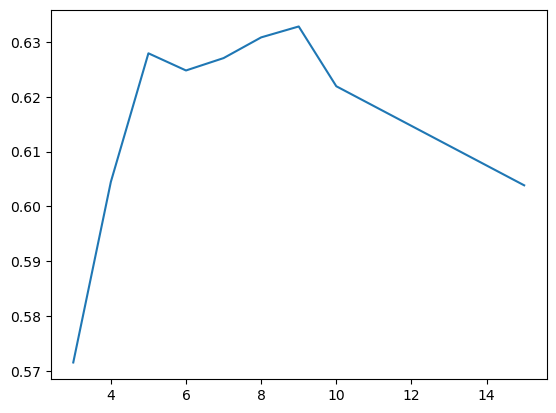

In [25]:
plt.plot(max_depth, RVE)
print(RVE)
# we will use 5 different values to choose our final model for max_depth : 5, 6, 7, 8 and 9
best_max_depths = [5, 6, 7, 8, 9]

In [26]:
RVE = []
booster = ["gbtree", "gblinear", "dart"]

for i in range(len(booster)):
    mdl = XGBRegressor(booster=booster[i])
    RVE.append(test_model(mdl, XGB_train_datasets[1], XGB_test_datasets[1]))

[0.6247798698763536, 0.39144552422844914, 0.6247798670734682]


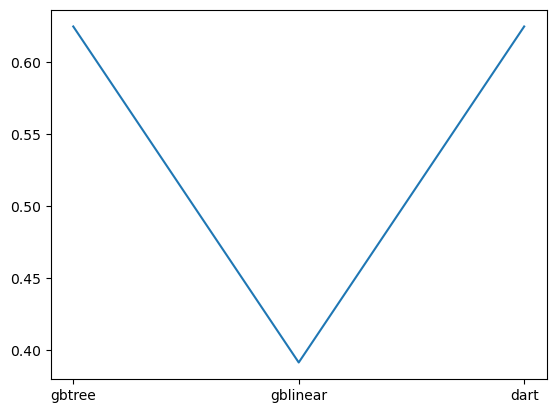

In [27]:
plt.plot(booster, RVE)
print(RVE)
# since the default booster (gbtree) gives the same result as dart and is better than gblinear, we will continue using it

In [28]:
RVE = []
etas = [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.7]

for i in range(len(etas)):
    mdl = XGBRegressor(eta=etas[i])
    RVE.append(test_model(mdl, XGB_train_datasets[1], XGB_test_datasets[1]))

[0.34012085143353366, 0.6012821113123934, 0.6180078812555263, 0.631763992362971, 0.6404571322255557, 0.6247798698763536, 0.5713157895087935, 0.530695674092605]


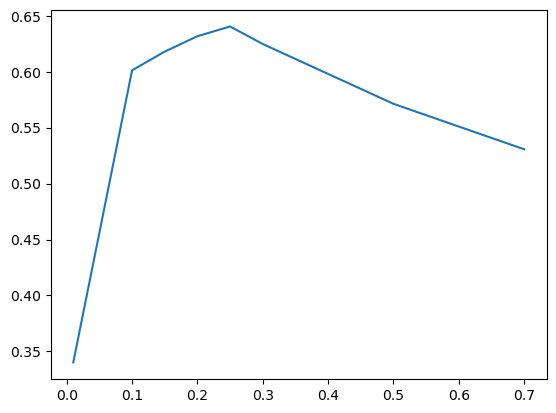

In [29]:
plt.plot(etas, RVE)
print(RVE)
# we will use 3 different eta to choose the final model : 0.2, 0.25 and 0.3
best_etas = [0.2, 0.25, 0.3]

In [30]:
RVE = []
gammas = [0, 0.1, 0.5, 1, 5]

for i in range(len(gammas)):
    mdl = XGBRegressor(gamma=gammas[i])
    RVE.append(test_model(mdl, XGB_train_datasets[1], XGB_test_datasets[1]))

[0.6247798698763536, 0.5972045516766978, 0.5168228105125237, 0.4619422471888066, 0.23477277457724366]


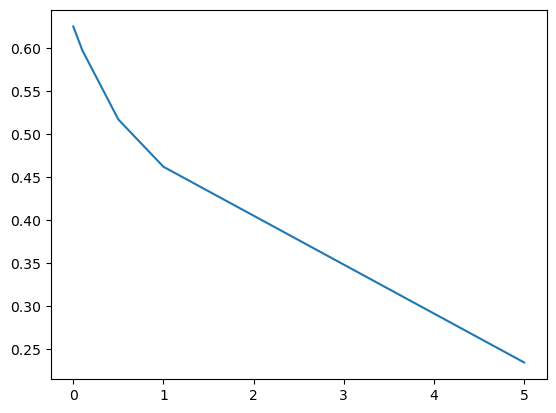

In [31]:
plt.plot(gammas, RVE)
print(RVE)
# we can see that the default parameter (0) yields the best results

In [32]:
RVE = []
lambdas = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]

for i in range(len(lambdas)):
    mdl = XGBRegressor(reg_lambda=lambdas[i])
    RVE.append(test_model(mdl, XGB_train_datasets[1], XGB_test_datasets[1]))

[0.6232818861413356, 0.6247798698763536, 0.6327757307643725, 0.6416211988346366, 0.6393962933664545, 0.6491103764285772, 0.6375850996922017, 0.6466367231812744, 0.6434834563060929, 0.6383837336683151, 0.6450321255586338, 0.6387483088306765]


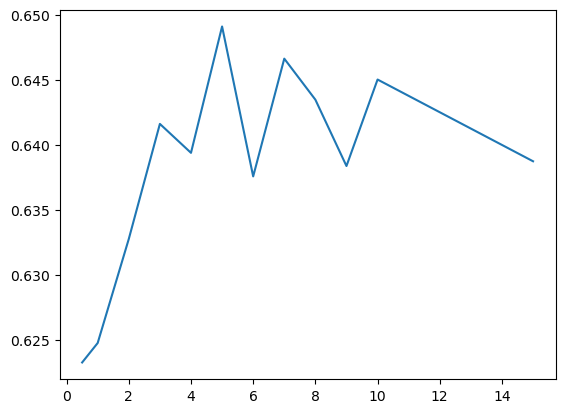

In [33]:
plt.plot(lambdas, RVE)
print(RVE)
# with the results being so different form one another while only changing the value by one, we chose to keep the best value after the rise, meaning a lambda of 3

In [34]:
RVE = []
alphas = [0.1, 0.5, 1, 5, 10, 15, 20]

for i in range(len(alphas)):
    mdl = XGBRegressor(alpha=alphas[i])
    RVE.append(test_model(mdl, XGB_train_datasets[1], XGB_test_datasets[1]))

[0.6386858148715846, 0.6403414887713739, 0.6409354034259845, 0.6153034557640698, 0.5329802675742831, 0.47561066176159905, 0.43063823850248895]


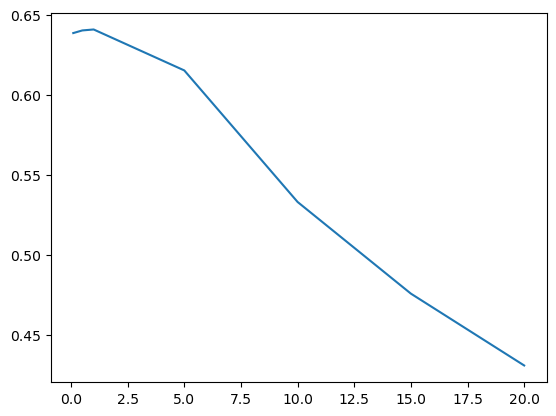

In [35]:
plt.plot(alphas, RVE)
print(RVE)
# since the difference is negligible, we wil keep the default value of 1

To chose the best model for XGBoost, we will try changing the max_depth, eta and change lambda to 3.

In [36]:
RVE = []
RVE_XGB = []

for i in range(len(XGB_train_datasets)):
    print("new dataset")
    RVE = []
    for max_depth in best_max_depths:
        for eta in best_etas:
            mdl=XGBRegressor(max_depth=max_depth, eta=eta, reg_lambda=3)
            RVE.append(test_model(mdl, XGB_train_datasets[i], XGB_test_datasets[i]))
    RVE_XGB.append(np.array(RVE).reshape(len(best_max_depths),len(best_etas)))

new dataset
new dataset
new dataset
new dataset


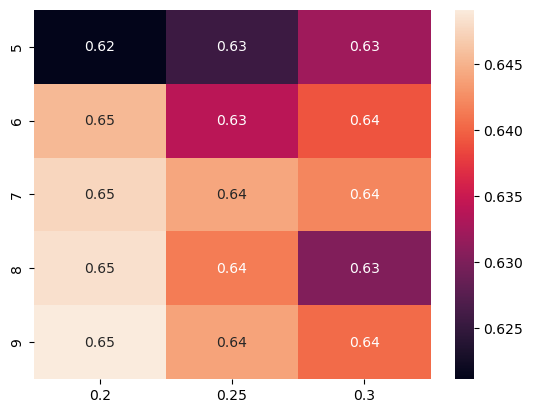

C:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


0.20    0.6491
0.25    0.6441
0.30    0.6420
dtype: float64


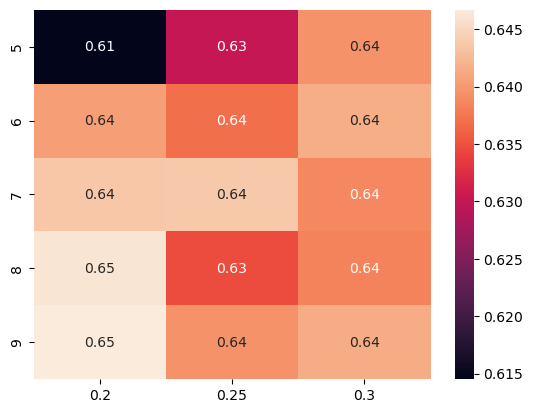

C:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


0.20    0.6467
0.25    0.6437
0.30    0.6416
dtype: float64


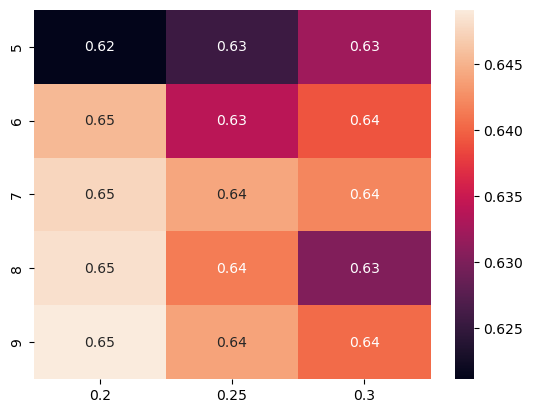

C:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


0.20    0.6491
0.25    0.6441
0.30    0.6420
dtype: float64


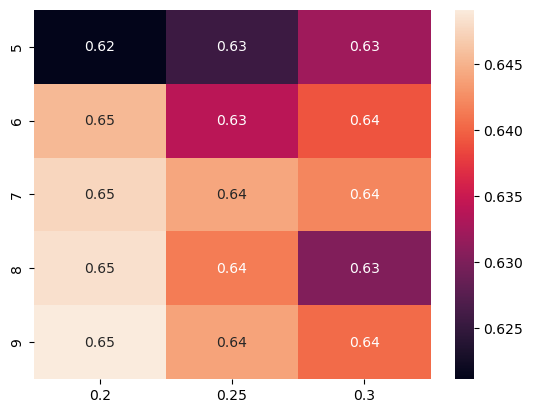

0.20    0.6491
0.25    0.6441
0.30    0.6420
dtype: float64


C:\Users\antoi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [37]:
HeatMap_XGB_df = []
for i in range(len(RVE_XGB)):
    HeatMap_XGB_df.append(pd.DataFrame(RVE_XGB[i], columns = best_etas, index = best_max_depths).round(4))
    sns.heatmap(data=HeatMap_XGB_df[i], annot=True, xticklabels=best_etas, yticklabels=best_max_depths)
    plt.show()
    print(np.max(HeatMap_XGB_df[i]))

The best result we achieved with XGBoost is with either non-scaled standard scaled or P-transformed data with a max_depth of 9 and a eta of 0.2. It achievec an RVE of 0.6491.

#### Multilayer perceptron

values to test : hidden_layer_sizes, activation, solver, alpha

In [52]:
RVE = []

for i in range(len(train_datasets)):
    mdl = MLPRegressor()
    RVE.append(test_model(mdl, train_datasets[i], test_datasets[i]))

In [53]:
MLP_train_datasets = []
MLP_test_datasets = []
MLP_train_datasets_str = []

best_RVE = sorted(RVE, reverse=True)[0:3] # we choose the 3 best datasets
for RVEs in best_RVE:
    index = RVE.index(RVEs)
    print(train_datasets_str[index]) # these are the datasets used
    MLP_train_datasets.append(train_datasets[index])
    MLP_test_datasets.append(test_datasets[index])
    MLP_train_datasets_str.append(train_datasets_str[index])

X_train_MMscaled
X_train_Sscaled
X_train_Ptransformer


Test different activation functions

In [67]:
RVE = []
RVE_MLP = []
activation = ['identity', 'logistic', 'tanh', 'relu']

for i in range(len(MLP_train_datasets)):
    print("new dataset")
    RVE = []
    for j in range(len(activation)):
        mdl = MLPRegressor(activation=activation[j])
        RVE.append(test_model(mdl, MLP_train_datasets[i], MLP_test_datasets[i]))
    RVE_MLP.append(np.array(RVE).reshape(len(activation)))

new dataset
new dataset
new dataset


[array([0.43219499, 0.45642245, 0.43262289, 0.57325618]), array([0.43637991, 0.4111403 , 0.44821436, 0.57281532]), array([0.43492187, 0.42636721, 0.4523375 , 0.56493751])]


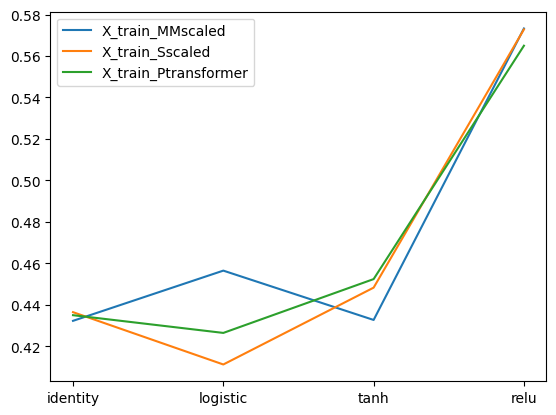

In [68]:
print(RVE_MLP)
for i in range(len(RVE_MLP)):
    plt.plot(activation, RVE_MLP[i], label=MLP_train_datasets_str[i])
plt.legend()

relu seems to be the best activation for all datasets.

Test different solvers

In [69]:
RVE = []
RVE_MLP = []
solver = ['lbfgs', 'sgd', 'adam']

for i in range(len(MLP_train_datasets)):
    print("new dataset")
    RVE = []
    for j in range(len(solver)):
        mdl = MLPRegressor(solver=solver[j])
        RVE.append(test_model(mdl, MLP_train_datasets[i], MLP_test_datasets[i]))
    RVE_MLP.append(np.array(RVE).reshape(len(solver)))

new dataset
new dataset


/Users/frederic/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


new dataset


/Users/frederic/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[array([0.58395875, 0.42368969, 0.58215439]), array([0.54757754, 0.45851643, 0.53696994]), array([0.55816452, 0.47423782, 0.58402882])]


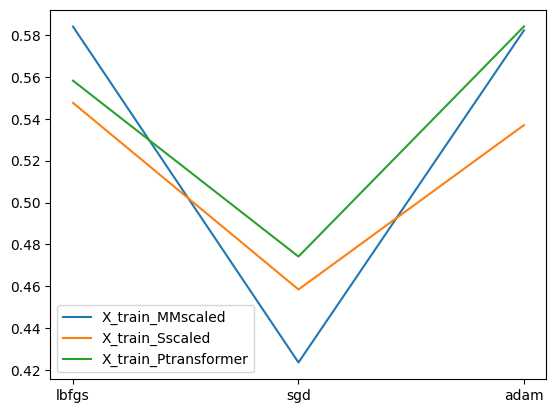

In [70]:
print(RVE_MLP)
for i in range(len(RVE_MLP)):
    plt.plot(solver, RVE_MLP[i], label=MLP_train_datasets_str[i])
plt.legend()

adam seems to be the best solver for all datasets

testing different layersizes, using "adam" and "relu" already

In [72]:
RVE = []
RVE_MLP = []
layers = [(100),(500),(1000),(100,100,100),(500,500,500)]

for i in range(len(MLP_train_datasets)):
    print("new dataset")
    RVE = []
    for j in range(len(layers)):
        mdl = MLPRegressor(hidden_layer_sizes=layers[j], solver ="adam", activation = "relu")
        RVE.append(test_model(mdl, MLP_train_datasets[i], MLP_test_datasets[i]))
    RVE_MLP.append(np.array(RVE).reshape(len(layers)))

new dataset
new dataset
new dataset


[array([0.56591616, 0.6032617 , 0.618715  , 0.61410229, 0.63388496]), array([0.53786174, 0.59314036, 0.5831591 , 0.62480227, 0.6482432 ]), array([0.51924939, 0.59040396, 0.57959993, 0.63477039, 0.63986695])]


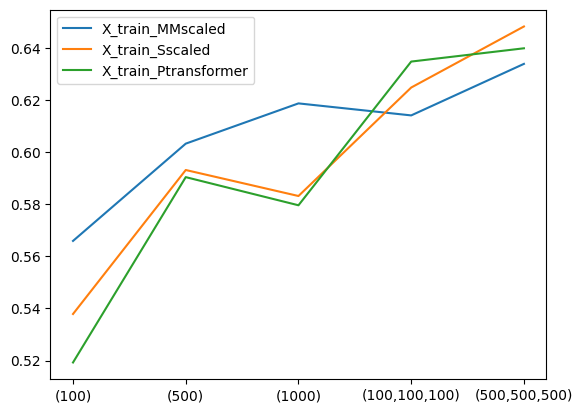

In [75]:
print(RVE_MLP)
layersled = ["(100)","(500)","(1000)","(100,100,100)","(500,500,500)"]
for i in range(len(RVE_MLP)):
    plt.plot(layersled, RVE_MLP[i], label=MLP_train_datasets_str[i])
plt.legend()

In [76]:
RVE = []
RVE_MLP = []
layers = [(1000),(500),(500,500,500,500,500),(1000,1000,1000)]

for i in range(len(MLP_train_datasets)):
    print("new dataset")
    RVE = []
    for j in range(len(layers)):
        mdl = MLPRegressor(hidden_layer_sizes=layers[j], solver ="adam", activation = "relu")
        RVE.append(test_model(mdl, MLP_train_datasets[i], MLP_test_datasets[i]))
    RVE_MLP.append(np.array(RVE).reshape(len(layers)))

new dataset
new dataset
new dataset


[array([0.60477857, 0.59920598, 0.63091589, 0.63193529]), array([0.60749847, 0.59787079, 0.64237261, 0.62089307]), array([0.59905225, 0.58571012, 0.64539913, 0.63766893])]


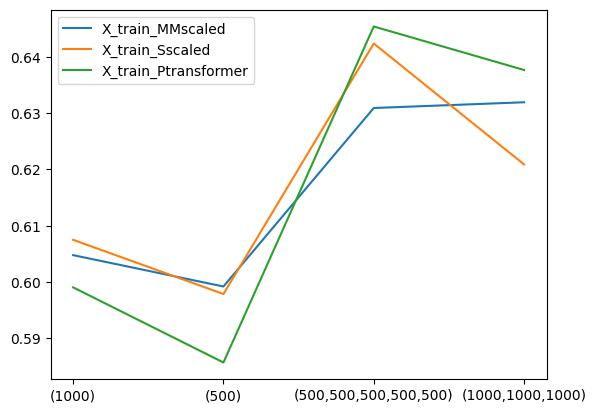

In [78]:
print(RVE_MLP)
layersled = ["(1000)","(500)","(500,500,500,500,500)","(1000,1000,1000)"]
for i in range(len(RVE_MLP)):
    plt.plot(layersled, RVE_MLP[i], label=MLP_train_datasets_str[i])
plt.legend()

testing different regularizations

In [81]:

RVE = []
RVE_MLP = []
alphas = [0.00001,0.0001,0.001,0.1,1]

for i in range(len(MLP_train_datasets)):
    print("new dataset")
    RVE = []
    for j in range(len(alphas)):
        mdl = MLPRegressor(alpha=alphas[j], solver ="adam", activation = "relu",hidden_layer_sizes=(500,500,500))
        RVE.append(test_model(mdl, MLP_train_datasets[i], MLP_test_datasets[i]))
    RVE_MLP.append(np.array(RVE).reshape(len(alphas)))

new dataset
new dataset
new dataset


[array([0.63267209, 0.64336625, 0.63072526, 0.62272304, 0.596375  ]), array([0.64821361, 0.64012468, 0.64021456, 0.61809489, 0.61918412]), array([0.64345009, 0.64313827, 0.65237241, 0.60363461, 0.62523775])]


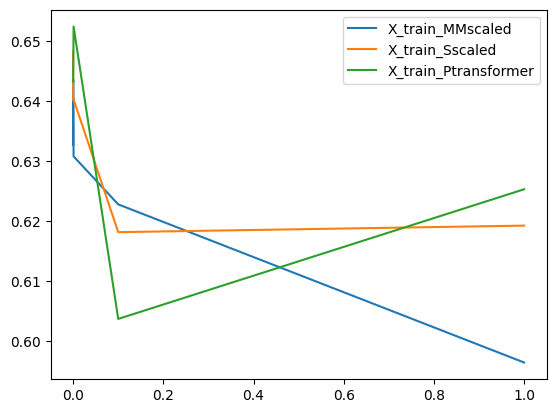

In [82]:
print(RVE_MLP)
for i in range(len(RVE_MLP)):
    plt.plot(alphas, RVE_MLP[i], label=MLP_train_datasets_str[i])
plt.legend()

### Final results


After testing all the models, the best model is the support vector machine with the dataset of linear PCA and an epsilon of 0.01. It achieves an RVE of 0.676.

We will then train this model on the whole training dataset. But first we will have to transform it using linear PCA.

#### Linear PCA on the full training dataset

Scaling of the full dataset:

In [14]:
X_train_complete_continuous, X_train_complete_categorical = X_train_complete[:, :43], X_train_complete[:, 43:]
X_ivs_continuous, X_ivs_categorical = X_ivs[:, :43], X_ivs[:, 43:]

In [15]:
Sscaler.fit(X_train_complete_continuous)
X_train_complete_Sscaled = Sscaler.transform(X_train_complete_continuous)
X_ivs_Sscaled =  Sscaler.transform(X_ivs_continuous)

In [16]:
X_train_complete_Sscaled = np.hstack((X_train_complete_Sscaled, X_train_complete_categorical))
X_ivs_Sscaled = np.hstack((X_ivs_Sscaled, X_ivs_categorical))

In [17]:
pca = PCA(n_components=300) # maybe try with less or more components
pca.fit(X_train_complete_Sscaled) # we use the data scaled with standard scaler since it follows the two rules for PCA : centered and unit variance

PCA(n_components=300)

In [18]:
X_train_complete_Sscaled_PCA = pca.transform(X_train_complete_Sscaled)
X_ivs_Sscaled_PCA = pca.transform(X_ivs_Sscaled)
print(X_train_complete_Sscaled_PCA.shape)

%store X_train_complete_Sscaled_PCA

(7337, 300)
Stored 'X_train_complete_Sscaled_PCA' (ndarray)


In [19]:
final_model=SVR(epsilon=0.01)
final_model.fit(X_train_complete_Sscaled_PCA, y_train_complete)

SVR(epsilon=0.01)

In [20]:
preds = final_model.predict(X_ivs_Sscaled_PCA)

In [21]:
with open("38.txt", "w") as f:
    for pred in preds:
        f.write(str(pred.round(3)) + "\n")